## Esame Metodi Numerici  10 gennaio 2025 - Ore 14

Si considerino i due sistemi lineari:

     A  x = b 

    A1 x1 = b1

dove A, A1 sono le matrici dei coefficienti, b e b1 sono i termini noti, ed x ed x1 sono i vettori incogniti da determinare.
I dati di questi due sistemi lineari sono contenuti nel file **test.mat**.


- Si risolva ciascuno dei sistemi lineari assegnati  utilizzato il metodo più adatto in base alle caratteristiche della matrice dei coefficienti, giustificando teoricamente le scelte effettuate.
                                      **punti 5**

Per il primo sistema lineare A x= b,  aggiungere una perturbazione dell' 1% sulla componente b[0]  del termine noto, e risolvere il sistema con termine noto perturbato. Calcolare quindi  l'errore relativo sulla soluzione e l'errore relativo sui dati e giustificare i risultati alla luce della teoria, richiamando il teorema relativo.
                                      **punti 3**


Per la lettura dei dati procedere nel seguente modo:

``from scipy.io import loadmat``

``import numpy as np``

``dati = loadmat('test')``

``A=dati["A"] ``

``A=A.astype(float)``

`` b=dati["b"] ``

`` b=b.astype(float)``

``A1=dati["A1"] ``

``A1=A1.astype(float)``

`` b1=dati["b1"] ``

`` b1=b1.astype(float)``

 

In [1]:
from scipy.io import loadmat
import numpy as np
import scipy as sp
from SolveTriangular import Lsolve, Usolve

dati = loadmat('test')

A=dati["A"] 
A=A.astype(float)
b=dati["b"]
b=b.astype(float)

A1=dati["A1"] 
A1=A1.astype(float)
b1=dati["b1"]
b1=b1.astype(float)

In [2]:
# punto 1
def mostra_caratteristiche(nome, A):
    print("Matrice:", nome)
    print("- dimensione:", A.shape)
    quadrata = A.shape[0] == A.shape[1]
    print("- quadrata:", quadrata)
    print("- condizionamento:", np.linalg.cond(A))
    if quadrata:
        print("- densità:", np.count_nonzero(A)/np.prod(A.shape))
        print("- diagonale strettamente dominante:", np.all(2*np.diag(np.abs(A)) > np.sum(np.abs(A), axis=1))) # |Aii| > sum_j!=i|Aij| => 2|Aii| > sum_j|Aij|
        print("- simmetrica:", np.all(A.T==A))
        print("- definita positiva:", np.all(np.linalg.eigvals(A)>0))
    else:
        print("- rango massimo:", np.linalg.matrix_rank(A)==np.min(A.shape))
    print()

mostra_caratteristiche("A", A) # piccola, quadrata, mediamente/mal condizionata, sparsa, simmetrica, definita positiva 
mostra_caratteristiche("A1", A1) # piccola, non quadrata (sistema sovradeterminato), mal condizionata, non a rango massimo

# A: La matrice è quadrata. Sebbene piccola, la matrice è sparsa e mal condizionata, quindi escludo le fattorizzazioni LU, QR e di Cholesky. Essendo simmetrica, definita positiva e NON a diagonale
# strettamente dominante, posso scegliere tra i metodi:
# - Gauss-Seidel
# - Gauss-Seidel SOR
# - Steepest-descent (metodo del gradiente)
# - Gradiente coniugato
# Scelgo di implementare il metodo del gradiente coniugato

# A1: La matrice non è quadrata, quindi rappresenta un sistema sovradeterminato. Oltre che essere mal condizionata, non ha rango massimo, rendendo quindi l'unico metodo di risoluzione possibile SVDLS.

def conjugate_gradient(A,b,x0,itmax,tol):
    n,m=A.shape
    if n!=m:
        print("Matrice non quadrata")
        return [],[]
    
    
    # inizializzare le variabili necessarie
    x = x0
    
    r = A@x-b
    p = -r 
    it = 0
    nb=np.linalg.norm(b)
    errore=np.linalg.norm(r)/nb
    vec_sol=[]
    vec_sol.append(x0.copy())
    vet_r=[]
    vet_r.append(errore)
    # utilizzare il metodo del gradiente coniugato per calcolare la soluzione
    while it <= itmax and errore >= tol: 
        it=it+1
        Ap=A@p
        alpha = -(r.T@p)/(p.T@Ap) 
        x = x + alpha*p
        vec_sol.append(x.copy())
        rtr_old=r.T@r
        r= r + alpha*Ap
        gamma=r.T@r/rtr_old 
        errore=np.linalg.norm(r)/nb
        vet_r.append(errore)
        p = -r +gamma*p # scendo lungo il gradiente coniugato sul piano formato da -r e p
    
    iterates_array = np.vstack([arr.T for arr in vec_sol])
    return x,vet_r,iterates_array,it

def SVDLS(A,b):
    m,n=A.shape  #numero di righe e  numero di colonne di A
    U,s,VT=sp.linalg.svd(A)  
    
    V=VT.T
    thresh=np.spacing(1)*m*s[0] ##Calcolo del rango della matrice, numero dei valori singolari maggiori di una soglia
    k=np.count_nonzero(s>thresh) 
    
    d=U.T@b
    d1=d[:k].reshape((k,1)) 
    s1=s[:k].reshape((k,1)) 
    
    c=d1/s1 
    x=V[:,:k]@c 
    residuo=np.linalg.norm(d[k:])**2
    return x,residuo

x0 = np.zeros_like(b)
itmax = 1000
tol = 1e-10
x, r_x, _, _ = conjugate_gradient(A, b, x0, itmax, tol)
x1, r_x1 = SVDLS(A1, b1)

# Soluzioni trasposte per comodità di stampa
print("Soluzione x:", x.T)
print("Soluzione x1:", x1.T)
print("Residuo x:", r_x[-1])
print("Residuo x1:", r_x1)

Matrice: A
- dimensione: (20, 20)
- quadrata: True
- condizionamento: 9999.999999997885
- densità: 0.08
- diagonale strettamente dominante: False
- simmetrica: True
- definita positiva: True

Matrice: A1
- dimensione: (20, 15)
- quadrata: False
- condizionamento: 5.697438059606206e+16
- rango massimo: False

Soluzione x: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Soluzione x1: [[0.5210993  1.25827182 1.27889527 0.46087355 0.89024294 1.04762977
  0.29616227 0.59585228 1.13383321 0.94430646 1.32127485 0.97301581
  0.15568769 0.79644108 1.09968922]]
Residuo x: 4.342304437574225e-12
Residuo x1: 1.7410406697260612e-30


In [3]:
# punto 2
# bb = b + perturbazione
bb = b.copy()
bb[0] += bb[0] / 100

## xx = soluzione con b perturbato
xx, r_xx, _, _ = conjugate_gradient(A, bb, x0, itmax, tol)

err = lambda x, expected: np.linalg.norm(x-expected)/np.linalg.norm(x)
print("Errore b:", err(bb, b))
print("Errore x:", err(xx, x))

# La matrice A è al limite tra il medio e il mal condizionamento (K=1000), che è un fattore che indica quanto una perturbazione sui dati cresce nella soluzione, difatti un errore piccolo sui dati di 
# partenza (0.00065) porta ad un errore piccolo ma comunque più elevato di quello sui dati (0.10438).

Errore b: 0.0006510394358331369
Errore x: 0.10437656774071682



- Dato il sistema lineare 
A3 x3 = b3
dove 

A3=np.array([[8,0,1],[0,12,2],[1,2,-14.0]])
b3= np.array([9.0, 14.0,  -11.0])

- Verificare senza calcolare il raggio spettrale della matrice di iterazione che il metodo di Gauss-Seidel converge, richiamando il teorema che garantisce la convergenza di Gauss-Seidel per classi particolari di 
matrici     **punti[1]**.
- Implementare il metodo di Gauss-Seidel  e risolvere il sistema lineare A3 x3= b3 con  **punti[3]**.

Totale **Punti 12**

In [4]:
# punto 3
A3=np.array([[8,0,1],[0,12,2],[1,2,-14.0]])
n3 = A3.shape[0]
b3= np.array([9.0, 14.0, -11.0]).reshape((n3, 1)) # b3 trasposto per diventare dei vettore termini noti

# mostriamo le caratteristiche della matrice
mostra_caratteristiche("A3", A3)

# Nonostante non sia definita positiva, il metodo di Gauss-Seidel converge in quanto la matrice A3 è a diagonale strettamente dominante

Matrice: A3
- dimensione: (3, 3)
- quadrata: True
- condizionamento: 1.7651462497889765
- densità: 0.7777777777777778
- diagonale strettamente dominante: True
- simmetrica: True
- definita positiva: False



In [5]:
# punto 4
def gauss_seidel(A,b,x0,toll,it_max):
    errore=1000
    d=np.diag(A)
    D=np.diag(d) 
    E=np.tril(A, -1) 
    F=np.triu(A, 1) 
    M=D+E 
    N=-F 
    invM=np.linalg.inv(M)
    T=invM@N 
    autovalori=np.linalg.eigvals(T)
    raggiospettrale=np.max(np.abs(autovalori)) 
    print("raggio spettrale Gauss-Seidel ",raggiospettrale)
    it=0
    er_vet=[]
    while it <= it_max and errore >= toll: 
        x,_=Lsolve(M, b+N@x0) 
        errore=np.linalg.norm(x-x0)/np.linalg.norm(x) 
        er_vet.append(errore)
        x0=x.copy()
        it=it+1
    return x,it,er_vet

x0 = np.zeros_like(b3)
toll = 1e-10
it_max = 1000
x3, it_x3, err_x3 = gauss_seidel(A3, b3, x0, toll, it_max)
print(f"Soluzione x3 ({it_x3} iterazioni): {x3}")
print("Errore finale x3:", err_x3[-1])

raggio spettrale Gauss-Seidel  0.03273809523809523
Soluzione x3 (9 iterazioni): [[1.]
 [1.]
 [1.]]
Errore finale x3: 5.068329982965351e-12


# Esercizio 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt

Implementare le function necessarie per costruire il polinomio interpolante di Lagrange. 
                                       **[4 punti]**
                                                         

In [7]:
# punto 1
def plagr(xnodi,j):
    xzeri=np.zeros_like(xnodi)
    n=xnodi.size
    if j==0:
       xzeri=xnodi[1:n] 
    else:
       xzeri=np.append(xnodi[:j], xnodi[j+1:n])
    
    num=np.poly(xzeri)
    den=np.polyval(num, xnodi[j])
    
    p=num/den
    return p



def InterpL(x, y, xx):
     n=x.size
     m=xx.size 
     L=np.zeros((m,n))
     for j in range(n):
        p=plagr(x, j)
        L[:,j]=np.polyval(p, xx) 
    
    
     return L@y

Sia assegnata la funzione $f(x)=cos(\pi x)+sin(\pi x)$, $ x \in [0,2]$,
facendo uso delle functions implementate precedentemente, si determini il polinomio p che interpola f nei nodi  x0 = 1, x1 = 1.5, x2 = 1.75 e si rappresenti in uno stesso grafico la funzione f, il polinomio p e i punti di interpolazione assegnati;
                                          **[2 punti]**

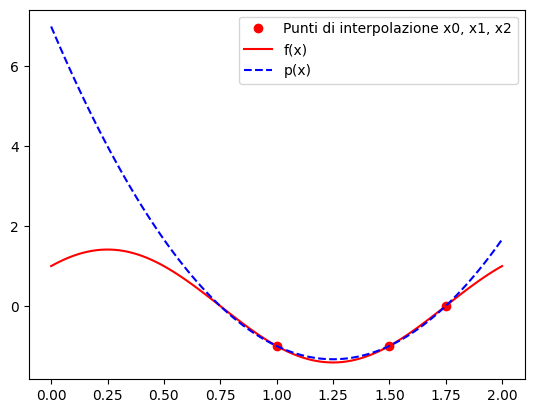

In [8]:
f = lambda x: np.cos(np.pi*x)+np.sin(np.pi*x)
x = np.array([1.0, 1.5, 1.75]) # x0, x1, x2
y = f(x)
xx = np.linspace(0, 2, 100)
yy = InterpL(x, y, xx)

plt.plot(x, y, "ro", label="Punti di interpolazione x0, x1, x2")
plt.plot(xx, f(xx), "r-", label="f(x)")
plt.plot(xx, yy, "b--", label="p(x)")
plt.legend()
plt.show()

 si calcoli il valore assunto dalla funzione errore E(x) := |f(x) − p(x)| nel punto $x^∗$ = 0.75 e si definisca teoricamente da cosa dipende l'errore che si compie quando al posto del polinomio interpolatore si considera la funzione che ha generato i dati, commentando opportunamente la formula 
                                                             **[3 punti]**

In [9]:
xs = 0.75 # x*
ys=f(xs)
yys=InterpL(x, y, np.array([xs]))[0]
            
err_xs = np.abs(ys-yys)
print("f(x*):", ys)
print("p(x*):", yys)
print("Errore x*:", err_xs)

# L'errore è dovuto dal fatto che il polinomio interpolatore assicura di avere il valore esatto f(x) nelle x usate per la costruzione dell'interpolazione, ma approssima negli altri punti.
# Aggiungendo ulteriori punti di interpolazione, soprattuto vicino allo 0 in cui non ce ne sono, il polinomio avrebbe avuto un'approssimazione migliore intorno ad x*.

f(x*): 1.1102230246251565e-16
p(x*): 3.3306690738754696e-16
Errore x*: 2.220446049250313e-16


si stabilisca qual è il polinomio interpolatore per f passante per i nodi $x^*$ 
, x0, x1 e x2.   **[1 punto]**

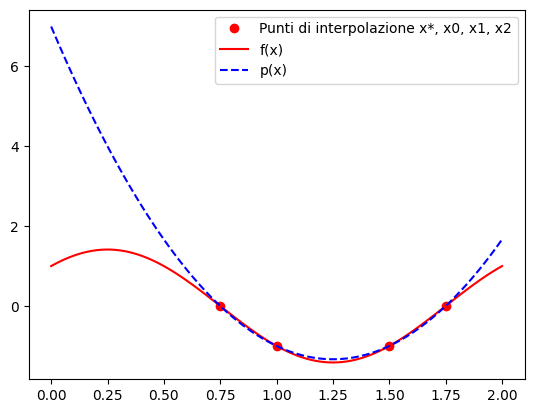

In [10]:
x2 = np.sort(np.append(x, [xs]))
y2 = f(x2)
yy2 = InterpL(x2, y2, xx)

plt.plot(x2, y2, "ro", label="Punti di interpolazione x*, x0, x1, x2")
plt.plot(xx, f(xx), "r-", label="f(x)")
plt.plot(xx, yy2, "b--", label="p(x)")
plt.legend()
plt.show()

Si calcoli la costante di Lebesgue per il problema di interpolazione in esame  e si dica che ruolo svolge nell'ambito dell'interpolazione polinomiale
                               **[3 punti]**

Totale **Punti 13**

## Domande Intelligenza Artificiale
**NB: Ogni risposta esatta:  +0.5 punti, ogni risposta errata: -0.5 punti. La mancanza di risposta:  0 punti**

**Risolvere un problema mediante Machine Learning significa**: A
- Fornire alla macchina i dati affinchè impari da sola a risolvere il problema
- Fornire alla macchina solo dati etichettati affinchè impari da sola a risolvere il problema
- Fornire alla macchina solo dati non etichettati affinchè impari da sola a risolvere il problema
- Fornire alla macchina le esatte istruzioni per risolvere il problema
edizione

**2  A cosa serve il validation set?** A

-  A trovare i migliori iperparametri del modello

-  Ad addestrare il modello

-  A testare il modello

-  A trovare le etichette dei dati di input

**3  Una classica rete CNN è solitamente composta da:** B

· Layer convolutivi seguiti da layer di pooling, flatten layer e neuroni completamente connessi

· Layer di pooling seguiti da layer convolutivi, flatten layer e neuroni completamente connessi

· Layer convolutivi seguiti da layer di pooling, flatten layer e softmax

· Layer di pooling seguiti da layer convolutivi, flatten layer e softmax

**4 Il livello softmax** A
- Trasforma i digits della rete in probabilità
- Trasforma le probabilità della rete in digits
- Normalizza i valori di input della rete
- È indispensabile nel task di regressione
lla rete

**5 Per una rete neurale, l’apprendimento è legato a:** A
- 	Minimizzare la funzione obiettivo
- Minimizzare la funzione di attivazione
- 	Massimizzare il valore dei pesi tramite l’algoritmo di back-propagation
- Massimizzare il valore della funzione di training


**Domande Aperte**

**6. Spiega in modo dettagliato come il learning rate influenza la convergenza di una rete neurale durante il training. Quali sono le conseguenze di un learning rate troppo alto o troppo basso nel training di una rete neurale. Descrivi le principali strategie di  aggiornamentodel  learning rate durante il training di una rete neurale.** [punti 1.5]

**7. Descrivi in dettaglio l'algoritmo di discesa del gradiente con momento. Quali sono le motivazioni che hanno portato alla sua introduzione rispetto alla discesa del gradiente standard? Fornisci la formula matematica dell'aggiornamento dei pesi in questo algoritmo e spiega il ruolo del termine di momento** [punti 3]

**6:** Il learning rate influisce sulla convergenza di una rete neurale durante il training in quanto indica la grandezza del "passo" che si compie ogni iterazione per cercare di minimizzare la funzione costo, che rappresenta l'errore compiuto dalla rete. Un learning rate troppo alto rischia di saltare completamente possibili punti di minimo oltrepassando completamente la discesa, mentre un learning rate troppo basso potrebbe rendere l'apprendimento troppo lento a causa di aggiustamenti troppo piccoli, oltre che rischiare di bloccare l'apprendimento in minimi locali o zone di plateau.
Le strategie principali di aggiornamento del learning rate sono:
- step-decay: Il learning rate è diminuito di un valore prestabilito ogni iterazione
- decrescita esponenziale: il learning rate è diminuito secondo una curva esponenziale (e^parametro negativo)
- decrescita in funzione del tempo: il learning rate è diminuito in funzione del numero di iterazioni svolte

**7:** L'algoritmo di discesa del gradiente con momento si basa sul concetto di "momentum" (o velocità), ovvero un fattore moltiplicatore che si assegna alla discesa nella direzione opposta al gradiente (massima decrescita) che varia in funzione dei gradienti passati: questo valore infatti aumenta di molto (e quindi favorisce la discesa) quando i gradienti passati tendono ad andare lungo la stessa direzione, mentre resta neutro quando i gradienti vanno in direzioni opposte per cercare di annullarli a vicenda.
La sua introduzione è avvenuta per creare un algoritmo che fosse una via di mezzo tra la discesa del gradiente standard, che scende secondo il valore dei gradienti quadrati portando spesso ad una decrescita troppo veloce e quindi ad un learning rate troppo basso in poco tempo, e il metodo RDMProp, che decresce invece secondo la media esponenziale dei gradienti.